# X-Ray Disease Classification Notebook (Modernized)

This notebook is an updated version of the previous one, ensuring compatibility with modern Python libraries and avoiding deprecated methods.

# NIH Chest X-ray Dataset

<h1>1. Business Problem </h1>

<h2> 1.1 Description </h2>

## National Institutes of Health Chest X-Ray Dataset

Chest X-ray exams are one of the most frequent and cost-effective medical imaging examinations available. However, clinical diagnosis of a chest X-ray can be challenging and sometimes more difficult than diagnosis via chest CT imaging. The lack of large publicly available datasets with annotations means it is still very difficult, if not impossible, to achieve clinically relevant computer-aided detection and diagnosis (CAD) in real world medical sites with chest X-rays. One major hurdle in creating large X-ray image datasets is the lack resources for labeling so many images. Prior to the release of this dataset, Openi was the largest publicly available source of chest X-ray images with 4,143 images available.

This NIH Chest X-ray Dataset is comprised of 112,120 X-ray images with disease labels from 30,805 unique patients. To create these labels, the authors used Natural Language Processing to text-mine disease classifications from the associated radiological reports. The labels are expected to be >90% accurate and suitable for weakly-supervised learning. The original radiology reports are not publicly available but you can find more details on the labeling process in this Open Access paper: "ChestX-ray8: Hospital-scale Chest X-ray Database and Benchmarks on Weakly-Supervised Classification and Localization of Common Thorax Diseases." (Wang et al.)

### Data limitations:
- 1. The image labels are NLP extracted so there could be some erroneous labels but the NLP labeling accuracy is estimated to be >90%.
 - 2. Very limited numbers of disease region bounding boxes (See BBox_list_2017.csv)
 - .Chest x-ray radiology reports are not anticipated to be publicly shared. Parties who use this public dataset are encouraged to share their “updated” image labels and/or new bounding boxes in their own studied later, maybe through manual annotation


<h2> 1.2 Source / useful links </h2>

Data Source : https://www.kaggle.com/nih-chest-xrays/data/home <br>
Research paper : http://openaccess.thecvf.com/content_cvpr_2017/papers/Wang_ChestX-ray8_Hospital-Scale_Chest_CVPR_2017_paper.pdf <br>
Research paper : https://lukeoakdenrayner.wordpress.com/2017/12/18/the-chestxray14-dataset-problems/ <br>
Research paper : https://arxiv.org/pdf/1711.05225.pdf <br>
Blog : https://lukeoakdenrayner.wordpress.com/2018/01/24/chexnet-an-in-depth-review/

<h2> 1.3 Real World / Business Objectives and Constraints </h2>

- 1. No strict latency constraints.

<h2> 2.1 Data </h2>

### File contents
Image format: 112,120 total images with size 1024 x 1024

**BBox_list_2017.csv: **Bounding box coordinates. Note: Start at x,y, extend horizontally w pixels, and vertically h pixels

- Image Index: File name
- Finding Label: Disease type (Class label)
- Bbox x
- Bbox y
- Bbox w
- Bbox h

**Data_entry_2017.csv:** Class labels and patient data for the entire dataset
- Image Index: File name
- Finding Labels: Disease type (Class label)
- Follow-up #
- Patient ID
- Patient Age
- Patient Gender
- View Position: X-ray orientation
- OriginalImageWidth
- OriginalImageHeight
- OriginalImagePixelSpacing_x
- OriginalImagePixelSpacing_y

**Class descriptions**

There are 15 classes (14 diseases, and one for "No findings"). Images can be classified as "No findings" or one or more disease classes:

- Atelectasis
- Consolidation
- Infiltration
- Pneumothorax
- Edema
- Emphysema
- Fibrosis
- Effusion
- Pneumonia
- Pleural_thickening
- Cardiomegaly
-  Nodule Mass
-  Hernia



### Goal

The goal is to use a simple model to classify x-ray images in Keras, the notebook how to use the flow_from_dataframe to deal with messier datasets


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import os
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
sns.set_style('whitegrid')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

<h1> 3. Exploratory Data Analysis </h1>

<h2> 3.1 Data Loading </h2>

In [3]:
database_image_folder_path = "dataset/images-224/images-224" #"dataset/images-1024/images-1024"#"C:/Users/zafer/OneDrive/Masaüstü/224NIH/dataset/images-224/images-224"
IMG_SIZE = (224,224)# reading the data
data = pd.read_csv("dataset/Data_Entry_2017.csv")
data.head()

Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_000.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           58              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   
3           81              M            PA                 2500     2048   
4           81              F            PA                 2582     2991   

   OriginalImagePixelSpacing[x     y]  Unnamed: 11  
0                        0.143  0.143          NaN  
1                        0.143  0.143          NaN  
2                        0.168  0.168          NaN  
3                        0.171  0.171          NaN  
4                        0.143  0.143          NaN

In [4]:
data.shape

(112120, 12)

In [5]:
data.describe()

Follow-up #     Patient ID    Patient Age  OriginalImage[Width  \
count  112120.000000  112120.000000  112120.000000        112120.000000   
mean        8.573751   14346.381743      46.901463          2646.078844   
std        15.406320    8403.876972      16.839923           341.246429   
min         0.000000       1.000000       1.000000          1143.000000   
25%         0.000000    7310.750000      35.000000          2500.000000   
50%         3.000000   13993.000000      49.000000          2518.000000   
75%        10.000000   20673.000000      59.000000          2992.000000   
max       183.000000   30805.000000     414.000000          3827.000000   

             Height]  OriginalImagePixelSpacing[x             y]  Unnamed: 11  
count  112120.000000                112120.000000  112120.000000          0.0  
mean     2486.438842                     0.155649       0.155649          NaN  
std       401.268227                     0.016174       0.016174          NaN  
min       966.000000                     0.115000       0.115000          NaN  
25%      2048.000000                     0.143000       0.143000          NaN  
50%      2544.000000                     0.143000       0.143000          NaN  
75%      2991.000000                     0.168000       0.168000          NaN  
max      4715.000000                     0.198800       0.198800          NaN

<h2> 3.2 Data cleaning </h2>

In [6]:
#drop unused columns
data = data[['Image Index','Finding Labels','Follow-up #','Patient ID','Patient Age','Patient Gender']]

# removing the rows which have patient_age >100
total = len(data)
print('No. of rows before removing rows having age >100 : ',len(data))
data = data[data['Patient Age']<100]
print('No. of rows after removing rows having age >100 : ',len(data))
print('No. of datapoints having age > 100 : ',total-len(data))

No. of rows before removing rows having age >100 :  112120
No. of rows after removing rows having age >100 :  112104
No. of datapoints having age > 100 :  16


In [7]:
# rows having no. of disease
data['Labels_Count'] = data['Finding Labels'].apply(lambda text: len(text.split('|')) if(text != 'No Finding') else 0)

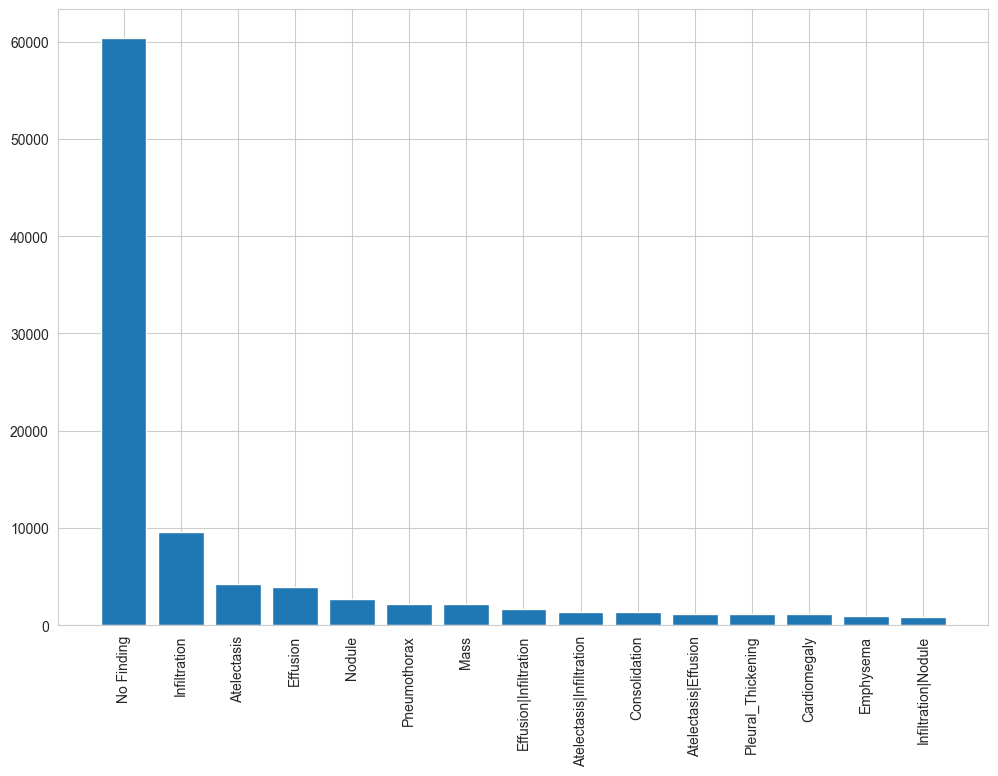

In [8]:
label_counts = data['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

<h2> 3.3 Data analysis </h2>

<h3> 3.3.1 Age distribution </h3>

<Figure size 2000x1500 with 0 Axes>

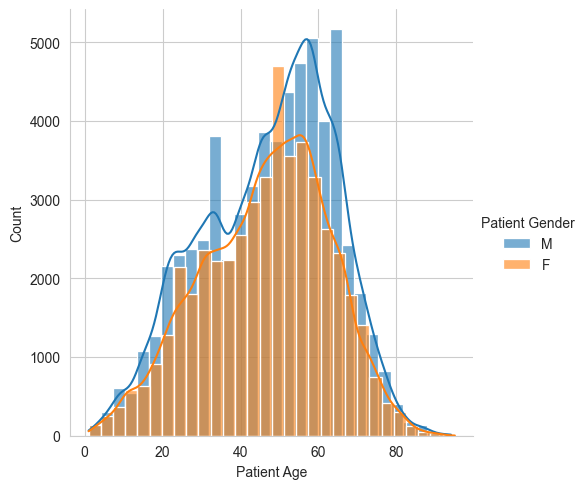

In [9]:
plt.figure(figsize=(20, 15))
sns.FacetGrid(data, hue='Patient Gender', height=5) \
    .map(sns.histplot, 'Patient Age', kde=True, bins=30, alpha=0.6) \
    .add_legend()

plt.show()

#### Observation - Both the gender have almost same distribution

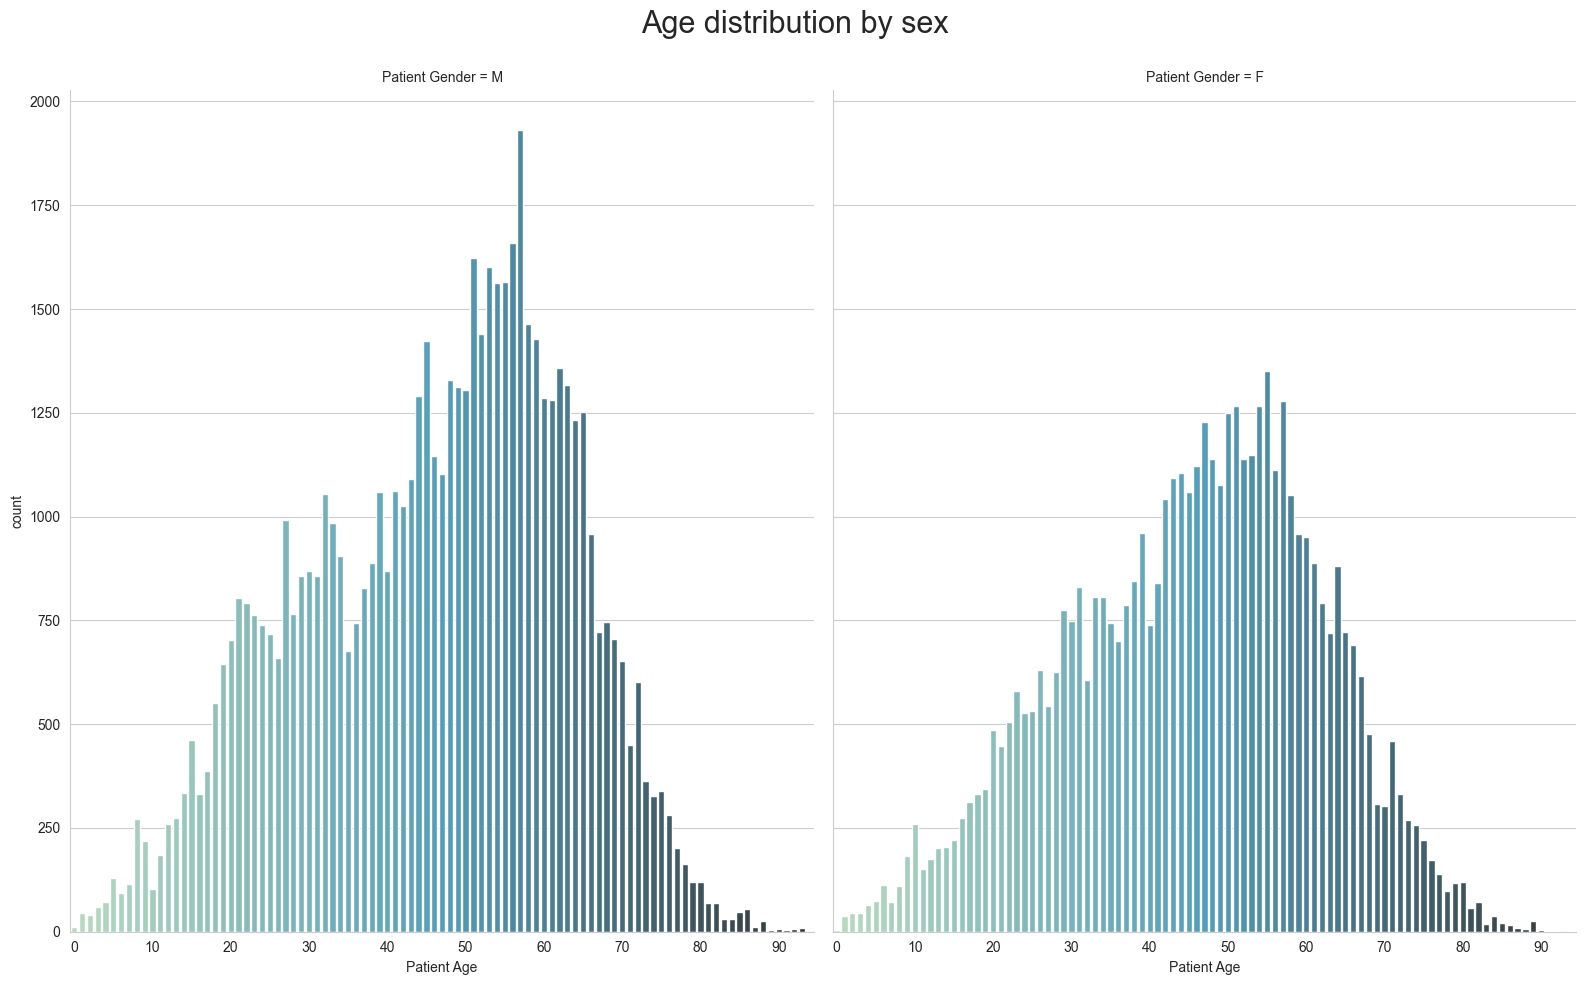

In [10]:

# Use sns.catplot instead of sns.factorplot
g = sns.catplot(
    x="Patient Age",
    col="Patient Gender",
    data=data,
    kind="count",
    height=10,  # Use `height` instead of `size`
    aspect=0.8,
    palette="GnBu_d"
)

# Set the x-axis tick positions and labels properly
tick_positions = np.arange(0, 100, step=10)
g.set(xticks=tick_positions)
g.set_xticklabels(labels=tick_positions)

# Add a title
g.fig.suptitle('Age distribution by sex', fontsize=22)

# Adjust the spacing for the title
g.fig.subplots_adjust(top=0.9)

plt.show()

<h3> 3.3.2 Disease distribution by age and sex </h3>

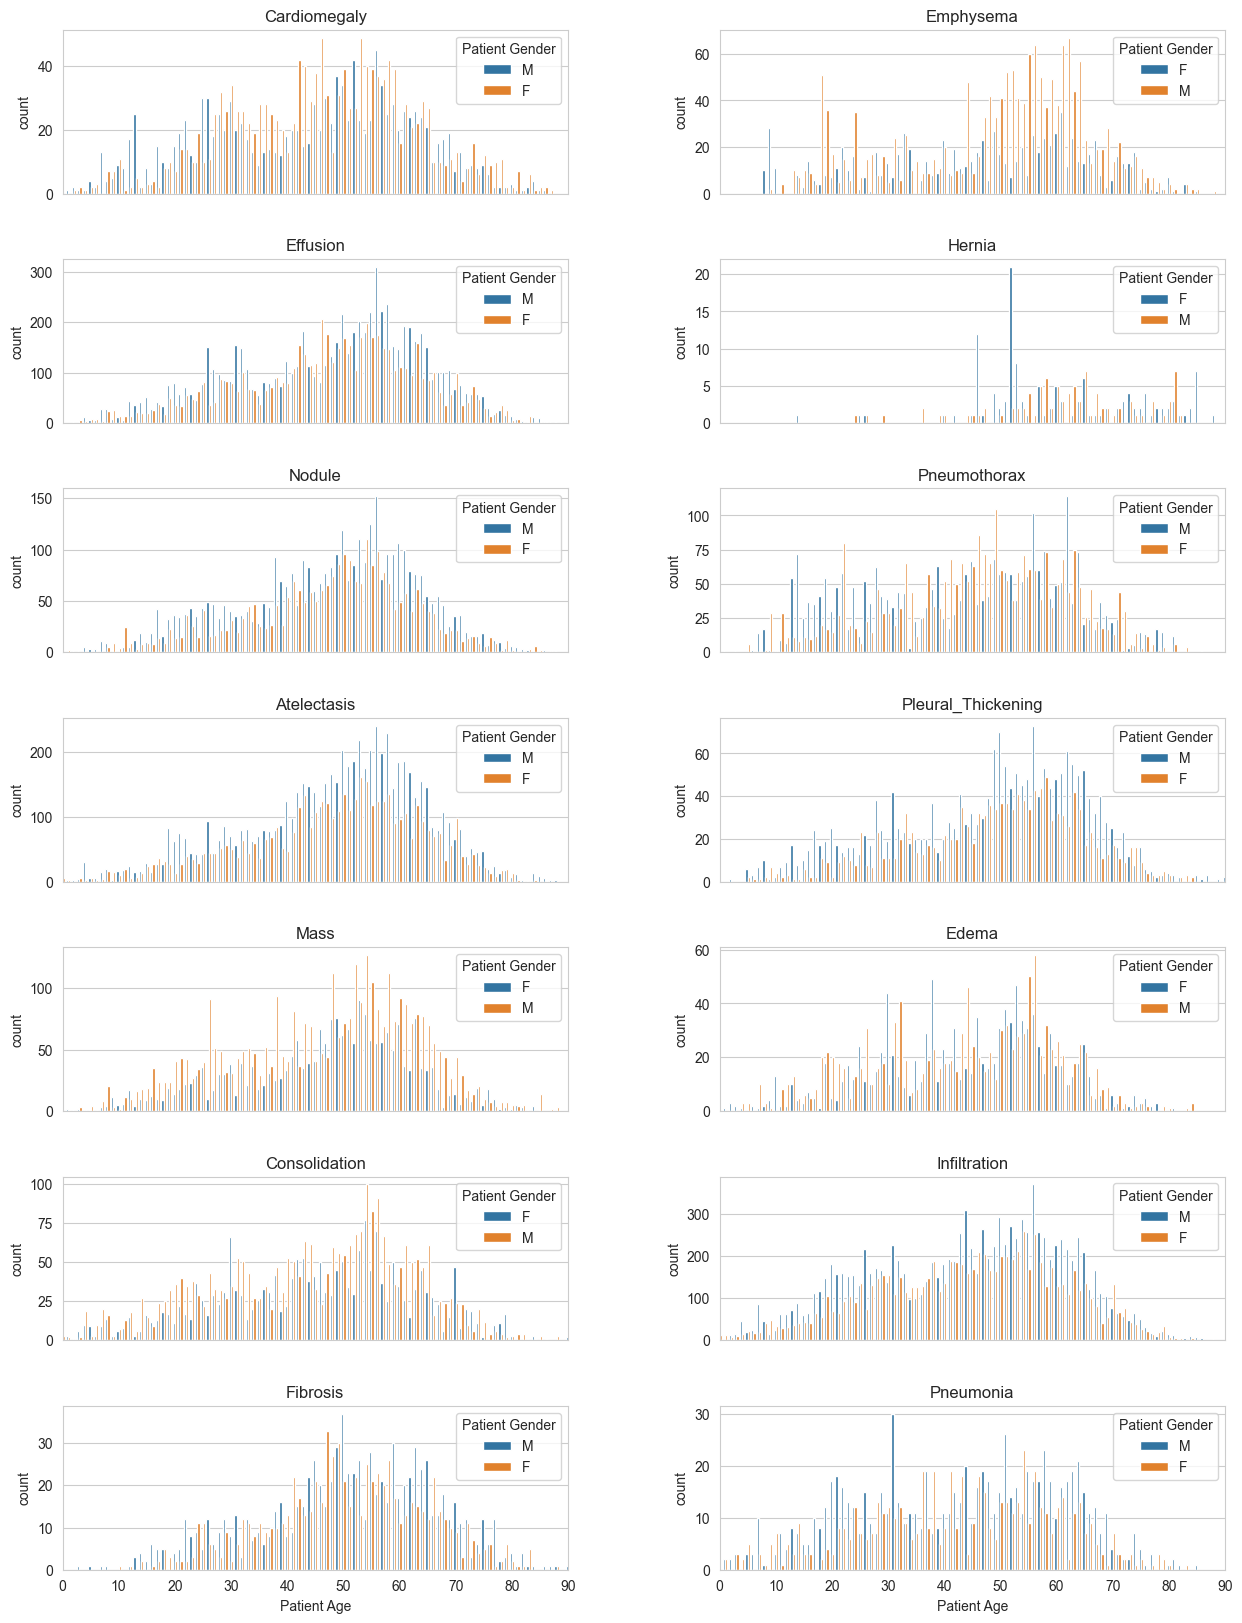

In [11]:
# Prepare the data
f, axarr = plt.subplots(7, 2, sharex=True, figsize=(15, 20))
pathology_list = ['Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia', 'Nodule', 
                  'Pneumothorax', 'Atelectasis', 'Pleural_Thickening', 'Mass', 
                  'Edema', 'Consolidation', 'Infiltration', 'Fibrosis', 'Pneumonia']
df = data[data['Finding Labels'] != 'No Finding']

# Define age bins for cleaner plots
age_bins = np.arange(0, 101, 10)
x_ticks = np.arange(0, 100, 10)

# Loop through pathologies and create subplots
i, j = 0, 0
for pathology in pathology_list:
    # Filter rows containing the current pathology
    pathology_df = df[df['Finding Labels'].str.contains(pathology, na=False)]
    
    # Ensure there's data to plot
    if not pathology_df.empty:
        g = sns.countplot(
            x='Patient Age', hue="Patient Gender", data=pathology_df, ax=axarr[i, j]
        )
        axarr[i, j].set_title(pathology)
        axarr[i, j].set_xlim(0, 90)
        axarr[i, j].set_xticks(x_ticks)
        axarr[i, j].set_xticklabels(x_ticks)
    else:
        axarr[i, j].set_title(f"{pathology} (No Data)")
        axarr[i, j].axis("off")  # Hide axes if no data

    # Update subplot indices
    j = (j + 1) % 2
    if j == 0:
        i = (i + 1) % 7

# Adjust subplot layout
f.subplots_adjust(hspace=0.4, wspace=0.3)

# Show the plots
plt.show()

<h3> 3.3.3 No. of each disease by patient gender </h3>

In [12]:
for pathology in pathology_list :
    data[pathology] = data['Finding Labels'].apply(lambda x: 1 if pathology in x else 0)

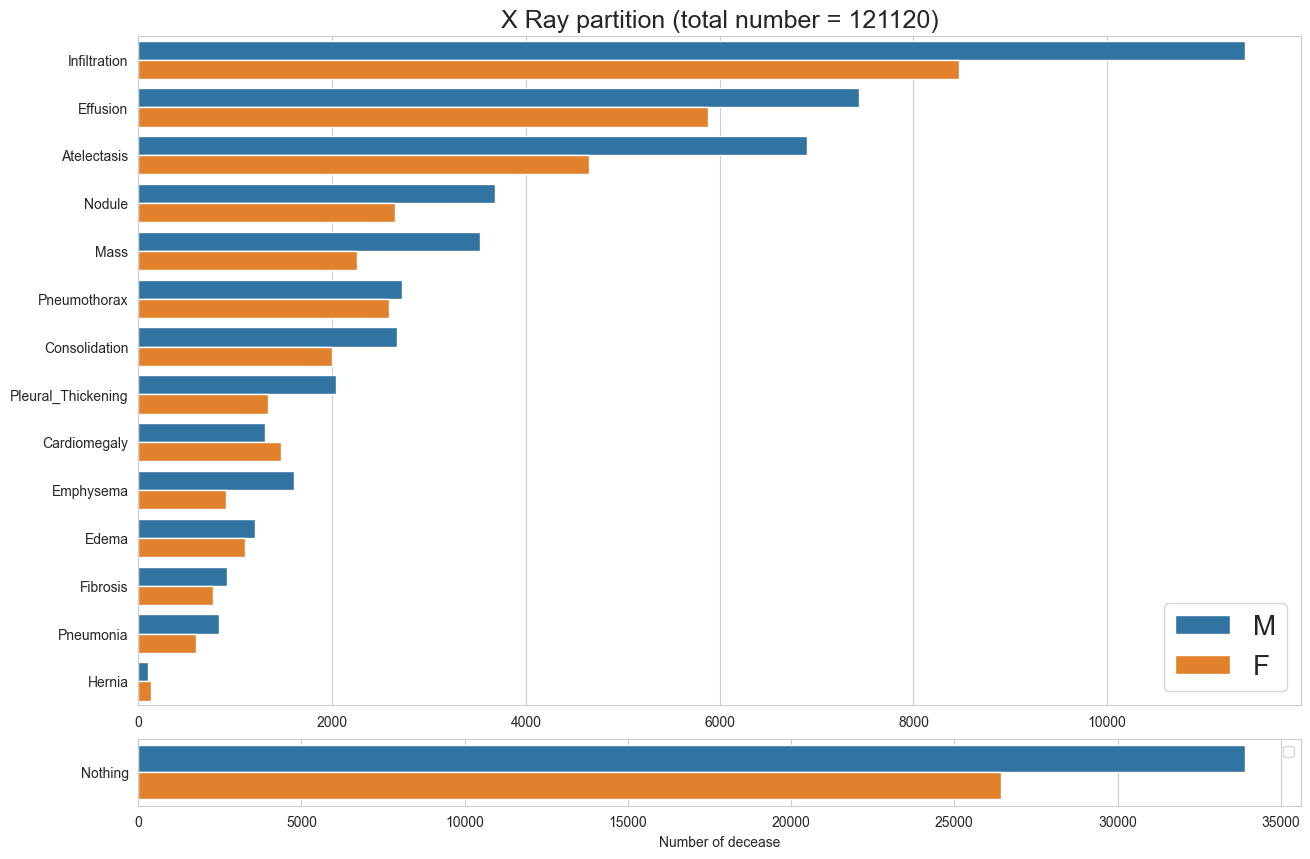

In [13]:
plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(8,1)
ax1 = plt.subplot(gs[:7, :])
ax2 = plt.subplot(gs[7, :])
data1 = pd.melt(data,
             id_vars=['Patient Gender'],
             value_vars = list(pathology_list),
             var_name = 'Category',
             value_name = 'Count')
data1 = data1.loc[data1.Count>0]
g=sns.countplot(y='Category',hue='Patient Gender',data=data1, ax=ax1, order = data1['Category'].value_counts().index)
ax1.set( ylabel="",xlabel="")
ax1.legend(fontsize=20)
ax1.set_title('X Ray partition (total number = 121120)',fontsize=18);

data['Nothing']=data['Finding Labels'].apply(lambda x: 1 if 'No Finding' in x else 0)

data2 = pd.melt(data,
             id_vars=['Patient Gender'],
             value_vars = list(['Nothing']),
             var_name = 'Category',
             value_name = 'Count')
data2 = data2.loc[data2.Count>0]
g=sns.countplot(y='Category',hue='Patient Gender',data=data2,ax=ax2)
ax2.set( ylabel="",xlabel="Number of decease")
ax2.legend('')
plt.subplots_adjust(hspace=.5)

<h3> 3.3.4 Display patient number by Follow-up in details </h3>

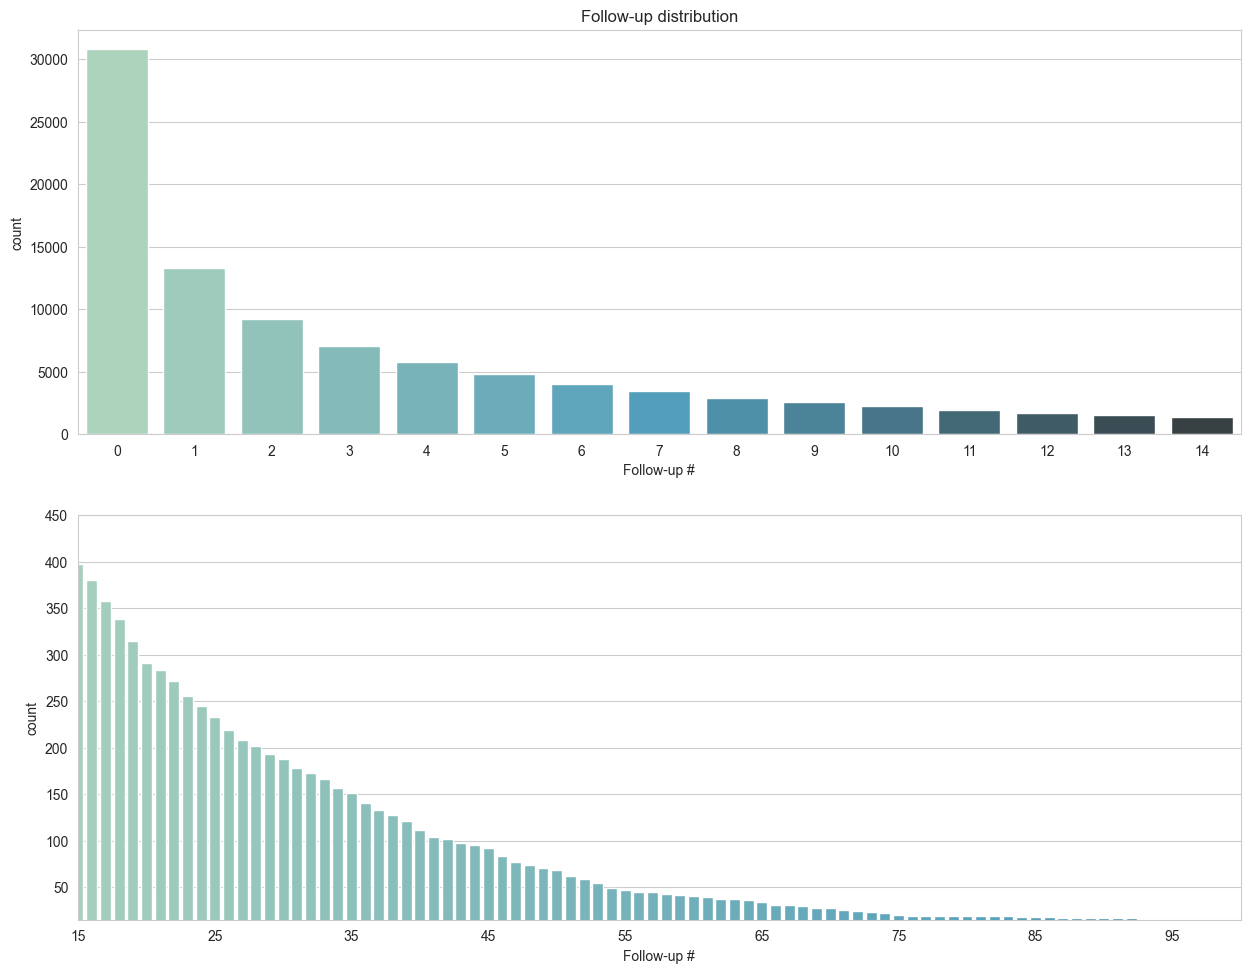

In [14]:
f, (ax1,ax2) = plt.subplots( 2, figsize=(15, 10))

df = data[data['Follow-up #']<15]
g = sns.countplot(x='Follow-up #',data=df,palette="GnBu_d",ax=ax1);

ax1.set_title('Follow-up distribution');
df = data[data['Follow-up #']>14]
g = sns.countplot(x='Follow-up #',data=df,palette="GnBu_d",ax=ax2);
x=np.arange(15,100,10)
g.set_ylim(15,450)
g.set_xlim(15,100)
g.set_xticks(x)
g.set_xticklabels(x)
f.subplots_adjust(top=1)

<h3> 3.3.5 ratio between one and multiple disease </h3>

In [15]:
df=data.groupby('Finding Labels').count().sort_values('Patient ID',ascending=False)
df1=df[['|' in index for index in df.index]].copy()
df2=df[['|' not in index for index in df.index]]
df2=df2[['No Finding' not in index for index in df2.index]]
df2['Finding Labels']=df2.index.values
df1['Finding Labels']=df1.index.values

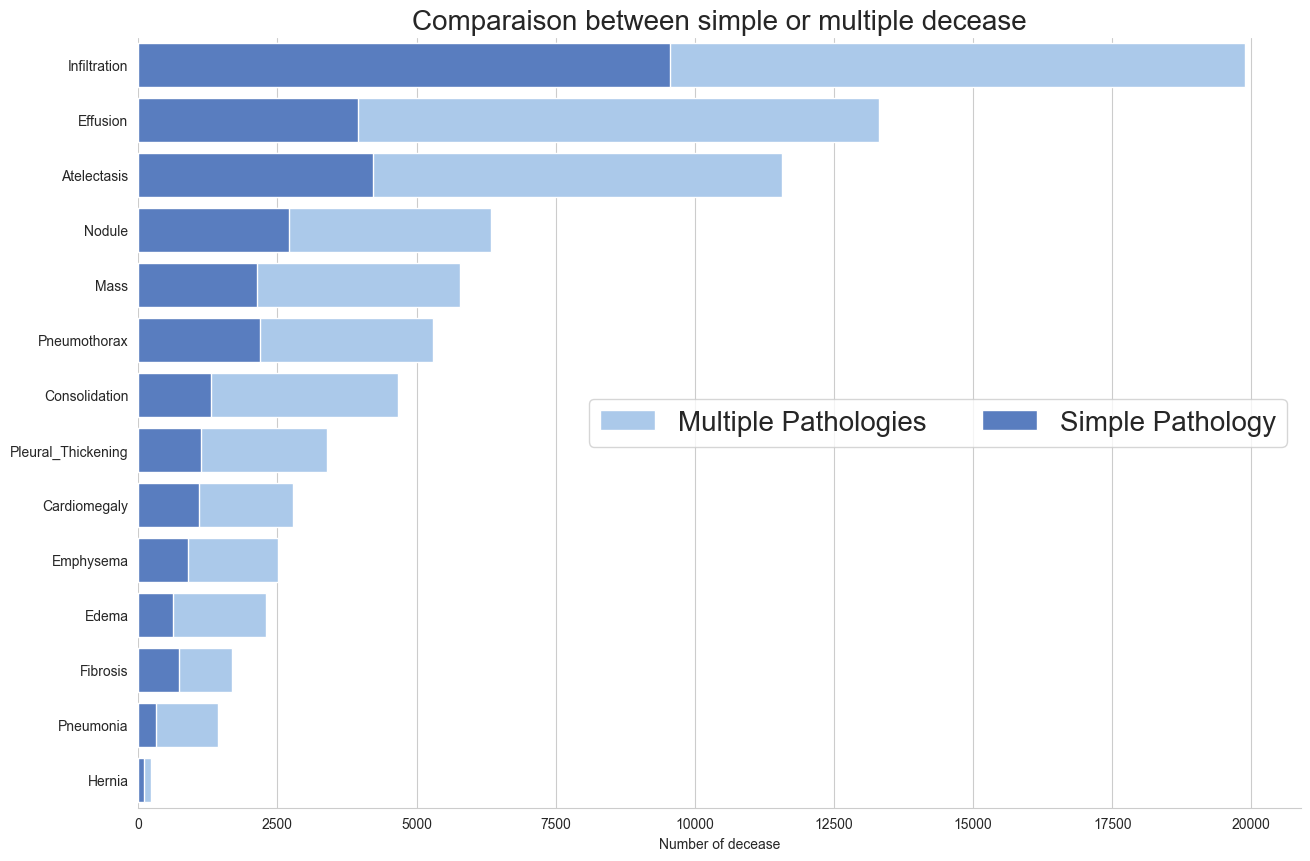

In [16]:
f, ax = plt.subplots(sharex=True,figsize=(15, 10))
sns.set_color_codes("pastel")
g=sns.countplot(y='Category',data=data1, ax=ax, order = data1['Category'].value_counts().index,color='b',label="Multiple Pathologies")
sns.set_color_codes("muted")
g=sns.barplot(x='Patient ID',y='Finding Labels',data=df2, ax=ax, color="b",label="Simple Pathology")
ax.legend(ncol=2, loc="center right", frameon=True,fontsize=20)
ax.set( ylabel="",xlabel="Number of decease")
ax.set_title("Comparaison between simple or multiple decease",fontsize=20)      
sns.despine(left=True)

<h3> 3.3.6 Plot most important pathologies groups for each desease </h3>

In [17]:
#we just keep groups of pathologies which appear more than 30 times
df3=df1.loc[df1['Patient ID']>30,['Patient ID','Finding Labels']]

for pathology in pathology_list:
    df3[pathology]=df3.apply(lambda x: x['Patient ID'] if pathology in x['Finding Labels'] else 0, axis=1)

df3.head(20)

Patient ID  \
Finding Labels                                  
Effusion|Infiltration                    1603   
Atelectasis|Infiltration                 1350   
Atelectasis|Effusion                     1165   
Infiltration|Nodule                       829   
Atelectasis|Effusion|Infiltration         737   
Cardiomegaly|Effusion                     484   
Consolidation|Infiltration                441   
Infiltration|Mass                         418   
Effusion|Pneumothorax                     403   
Effusion|Mass                             402   
Atelectasis|Consolidation                 398   
Mass|Nodule                               394   
Edema|Infiltration                        392   
Infiltration|Pneumothorax                 345   
Consolidation|Effusion                    337   
Emphysema|Pneumothorax                    337   
Effusion|Pleural_Thickening               251   
Effusion|Nodule                           249   
Atelectasis|Pneumothorax                  240   
Infiltration|Pleural_Thickening           210   

                                                      Finding Labels  \
Finding Labels                                                         
Effusion|Infiltration                          Effusion|Infiltration   
Atelectasis|Infiltration                    Atelectasis|Infiltration   
Atelectasis|Effusion                            Atelectasis|Effusion   
Infiltration|Nodule                              Infiltration|Nodule   
Atelectasis|Effusion|Infiltration  Atelectasis|Effusion|Infiltration   
Cardiomegaly|Effusion                          Cardiomegaly|Effusion   
Consolidation|Infiltration                Consolidation|Infiltration   
Infiltration|Mass                                  Infiltration|Mass   
Effusion|Pneumothorax                          Effusion|Pneumothorax   
Effusion|Mass                                          Effusion|Mass   
Atelectasis|Consolidation                  Atelectasis|Consolidation   
Mass|Nodule                                              Mass|Nodule   
Edema|Infiltration                                Edema|Infiltration   
Infiltration|Pneumothorax                  Infiltration|Pneumothorax   
Consolidation|Effusion                        Consolidation|Effusion   
Emphysema|Pneumothorax                        Emphysema|Pneumothorax   
Effusion|Pleural_Thickening              Effusion|Pleural_Thickening   
Effusion|Nodule                                      Effusion|Nodule   
Atelectasis|Pneumothorax                    Atelectasis|Pneumothorax   
Infiltration|Pleural_Thickening      Infiltration|Pleural_Thickening   

                                   Cardiomegaly  Emphysema  Effusion  Hernia  \
Finding Labels                                                                 
Effusion|Infiltration                         0          0      1603       0   
Atelectasis|Infiltration                      0          0         0       0   
Atelectasis|Effusion                          0          0      1165       0   
Infiltration|Nodule                           0          0         0       0   
Atelectasis|Effusion|Infiltration             0          0       737       0   
Cardiomegaly|Effusion                       484          0       484       0   
Consolidation|Infiltration                    0          0         0       0   
Infiltration|Mass                             0          0         0       0   
Effusion|Pneumothorax                         0          0       403       0   
Effusion|Mass                                 0          0       402       0   
Atelectasis|Consolidation                     0          0         0       0   
Mass|Nodule                                   0          0         0       0   
Edema|Infiltration                            0          0         0       0   
Infiltration|Pneumothorax                     0          0         0       0   
Consolidation|Effusion                        0          0       337       0   
Emphysema|P

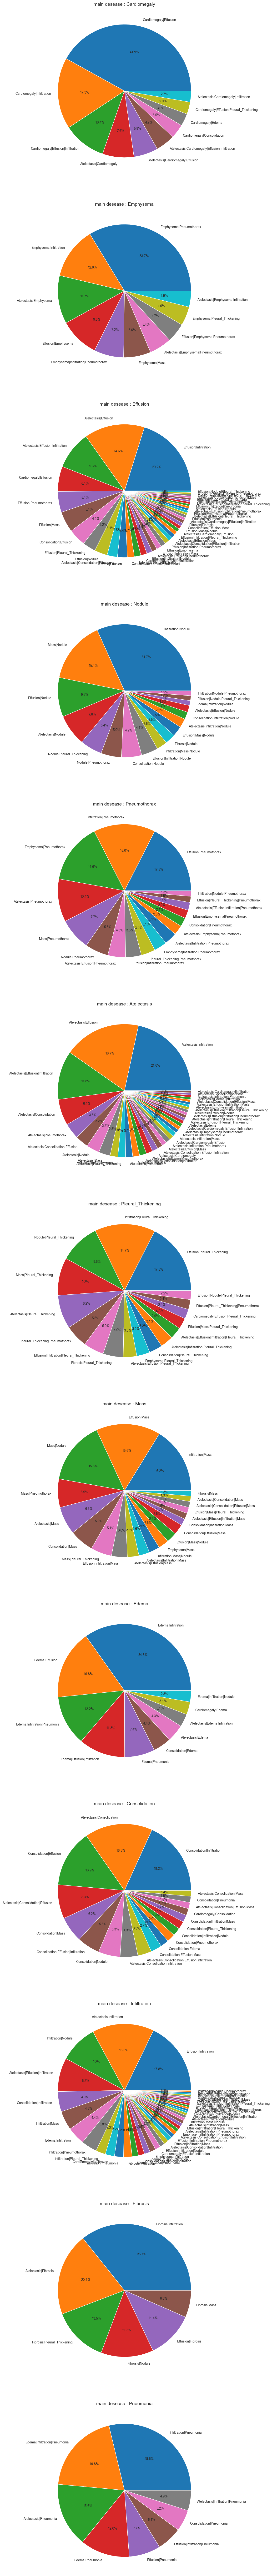

In [18]:
#'Hernia' has not enough values to figure here
df4=df3[df3['Hernia']>0]  # df4.size == 0
#remove 'Hernia' from list
pat_list=[elem for elem in pathology_list if 'Hernia' not in elem]

f, axarr = plt.subplots(13, sharex=True,figsize=(10, 140))
i=0
for pathology in pat_list :
    df4=df3[df3[pathology]>0]
    if df4.size>0:  #'Hernia' has not enough values to figure here
        axarr[i].pie(df4[pathology],labels=df4['Finding Labels'], autopct='%1.1f%%')
        axarr[i].set_title('main desease : '+pathology,fontsize=14)   
        i +=1


<h1> 4. Creating data for model </h1>

In [19]:
data = data[data['Patient Age']<100] #removing datapoints which having age greater than 100
data_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('..', 'input', 'images*', '*', '*.png'))}
print('Scans found:', len(data_image_paths), ', Total Headers', data.shape[0])
data['path'] = data['Image Index'].apply(data_image_paths.get)
data['Patient Age'] = data['Patient Age'].apply(lambda x: int(x))
data.sample(3)

Scans found: 0 , Total Headers 112104


Image Index Finding Labels  Follow-up #  Patient ID  Patient Age  \
98810   00026126_000.png     No Finding            0       26126           56   
21671   00005759_011.png       Effusion           11        5759           63   
108085  00029249_000.png     No Finding            0       29249           27   

       Patient Gender  Labels_Count  Cardiomegaly  Emphysema  Effusion  ...  \
98810               F             0             0          0         0  ...   
21671               F             1             0          0         1  ...   
108085              F             0             0          0         0  ...   

        Atelectasis  Pleural_Thickening  Mass  Edema  Consolidation  \
98810             0                   0     0      0              0   
21671             0                   0     0      0              0   
108085            0                   0     0      0              0   

        Infiltration  Fibrosis  Pneumonia  Nothing  path  
98810              0         0          0        1  None  
21671              0         0          0        0  None  
108085             0         0          0        1  None  

[3 rows x 23 columns]

In [20]:
data['Finding Labels'] = data['Finding Labels'].apply(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*data['Finding Labels'].apply(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        data[c_label] = data['Finding Labels'].apply(lambda finding: 1.0 if c_label in finding else 0)
data.sample(3)

All Labels (14): [np.str_('Atelectasis'), np.str_('Cardiomegaly'), np.str_('Consolidation'), np.str_('Edema'), np.str_('Effusion'), np.str_('Emphysema'), np.str_('Fibrosis'), np.str_('Hernia'), np.str_('Infiltration'), np.str_('Mass'), np.str_('Nodule'), np.str_('Pleural_Thickening'), np.str_('Pneumonia'), np.str_('Pneumothorax')]


Image Index             Finding Labels  Follow-up #  Patient ID  \
17683  00004769_001.png                                       1        4769   
76999  00018921_015.png  Infiltration|Pneumothorax           15       18921   
41324  00010695_015.png               Pneumothorax           15       10695   

       Patient Age Patient Gender  Labels_Count  Cardiomegaly  Emphysema  \
17683           36              F             0           0.0        0.0   
76999           43              F             2           0.0        0.0   
41324           28              F             1           0.0        0.0   

       Effusion  ...  Atelectasis  Pleural_Thickening  Mass  Edema  \
17683       0.0  ...          0.0                 0.0   0.0    0.0   
76999       0.0  ...          0.0                 0.0   0.0    0.0   
41324       0.0  ...          0.0                 0.0   0.0    0.0   

       Consolidation  Infiltration  Fibrosis  Pneumonia  Nothing  path  
17683            0.0           0.0       0.0        0.0        1  None  
76999            0.0           1.0       0.0        0.0        0  None  
41324            0.0           0.0       0.0        0.0        0  None  

[3 rows x 23 columns]

In [21]:
# keep at least 1000 cases
MIN_CASES = 1000
all_labels = [c_label for c_label in all_labels if data[c_label].sum()>MIN_CASES]
print('Clean Labels ({})'.format(len(all_labels)), 
      [(c_label,int(data[c_label].sum())) for c_label in all_labels])


Clean Labels (13) [(np.str_('Atelectasis'), 11558), (np.str_('Cardiomegaly'), 2776), (np.str_('Consolidation'), 4667), (np.str_('Edema'), 2302), (np.str_('Effusion'), 13316), (np.str_('Emphysema'), 2516), (np.str_('Fibrosis'), 1686), (np.str_('Infiltration'), 19891), (np.str_('Mass'), 5779), (np.str_('Nodule'), 6331), (np.str_('Pleural_Thickening'), 3384), (np.str_('Pneumonia'), 1430), (np.str_('Pneumothorax'), 5301)]


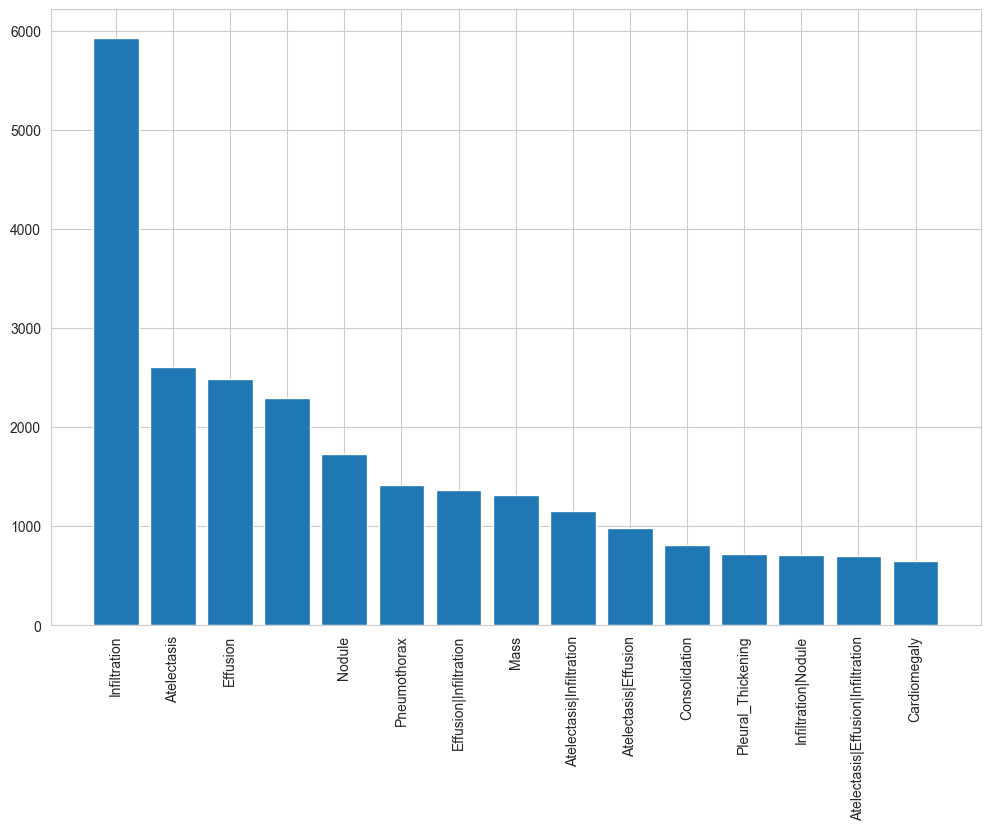

In [22]:
# since the dataset is very unbiased, we can resample it to be a more reasonable collection
# weight is 0.04 + number of findings
sample_weights = data['Finding Labels'].apply(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2
sample_weights /= sample_weights.sum()
data = data.sample(40000, weights=sample_weights)

label_counts = data['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)


In [23]:
# creating vector of diseases
data['disease_vec'] = data.apply(lambda x: [x[all_labels].values], 1).apply(lambda x: x[0])


In [24]:
data.iloc[0]['disease_vec']

array([1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
      dtype=object)

In [25]:
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(data, 
                                   test_size = 0.25, 
                                   random_state = 2018,
                                   stratify = data['Finding Labels'].apply(lambda x: x[:4]))
print('train', train_df.shape[0], 'validation', valid_df.shape[0])

train 30000 validation 10000


In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


core_idg = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)


In [27]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = database_image_folder_path
    print('## Ignore next message from keras, values are replaced anyways')

    # Create a copy to ensure the original dataframe remains unmodified
    in_df = in_df.copy()

    # Ensure the path column contains strings
    in_df[path_col] = in_df[path_col].astype(str)

    # Ensure the labels (y_col) are properly formatted as numeric arrays
    num_classes = 13  # Set for 13 diseases
    in_df[y_col] = in_df[y_col].apply(
        lambda x: np.array(x, dtype='float32') if isinstance(x, (list, np.ndarray)) and len(x) == num_classes else np.zeros(num_classes, dtype='float32')
    )

    # Generate the dataframe generator
    df_gen = img_data_gen.flow_from_dataframe(
        dataframe=in_df,
        directory=base_dir,
        x_col=path_col,
        y_col=y_col,
        class_mode='raw',  # Use 'raw' for multi-label or multi-hot encoding
        **dflow_args
    )

    # Explicitly stack classes to ensure a proper 2D array
    df_gen.classes = np.stack(in_df[y_col].values, axis=0)  # Ensure numeric and 2D
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()

    # Set filenames explicitly
    df_gen.filenames = in_df[path_col].values

    # Debug output
    print(f"Generator initialized with {df_gen.samples} samples and directory {base_dir}.")
    return df_gen


In [28]:
# Define the target size and batch sizes

# Create the training generator
train_gen = flow_from_dataframe(
    img_data_gen=core_idg,
    in_df=train_df,
    path_col='Image Index',
    y_col='disease_vec',
    target_size=IMG_SIZE,
    color_mode='grayscale',
    batch_size=32
)

# Create the validation generator
valid_gen = flow_from_dataframe(
    img_data_gen=core_idg ,
    in_df=valid_df,
    path_col='Image Index',
    y_col='disease_vec',
    target_size=IMG_SIZE,
    color_mode='grayscale',
    batch_size=256
)

# Create a single large batch for evaluation
test_X, test_Y = next(flow_from_dataframe(
    img_data_gen=core_idg , 
    in_df=valid_df, 
    path_col='Image Index',
    y_col='disease_vec', 
    target_size=IMG_SIZE,
    color_mode='grayscale',
    batch_size=1024
))

# Debugging raw output from train_gen
X_batch, Y_batch = next(train_gen)

print(f"X_batch shape: {X_batch.shape}, dtype: {X_batch.dtype}")
print(f"Y_batch shape: {Y_batch.shape}, dtype: {Y_batch.dtype}")
print(f"Y_batch example row: {Y_batch[0]}")


## Ignore next message from keras, values are replaced anyways
Found 30000 validated image filenames.
Generator initialized with 30000 samples and directory dataset/images-224/images-224.
## Ignore next message from keras, values are replaced anyways
Found 10000 validated image filenames.
Generator initialized with 10000 samples and directory dataset/images-224/images-224.
## Ignore next message from keras, values are replaced anyways
Found 10000 validated image filenames.
Generator initialized with 10000 samples and directory dataset/images-224/images-224.
X_batch shape: (32, 224, 224, 1), dtype: float32
Y_batch shape: (32,), dtype: object
Y_batch example row: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [29]:
test_Y = np.stack(test_Y)

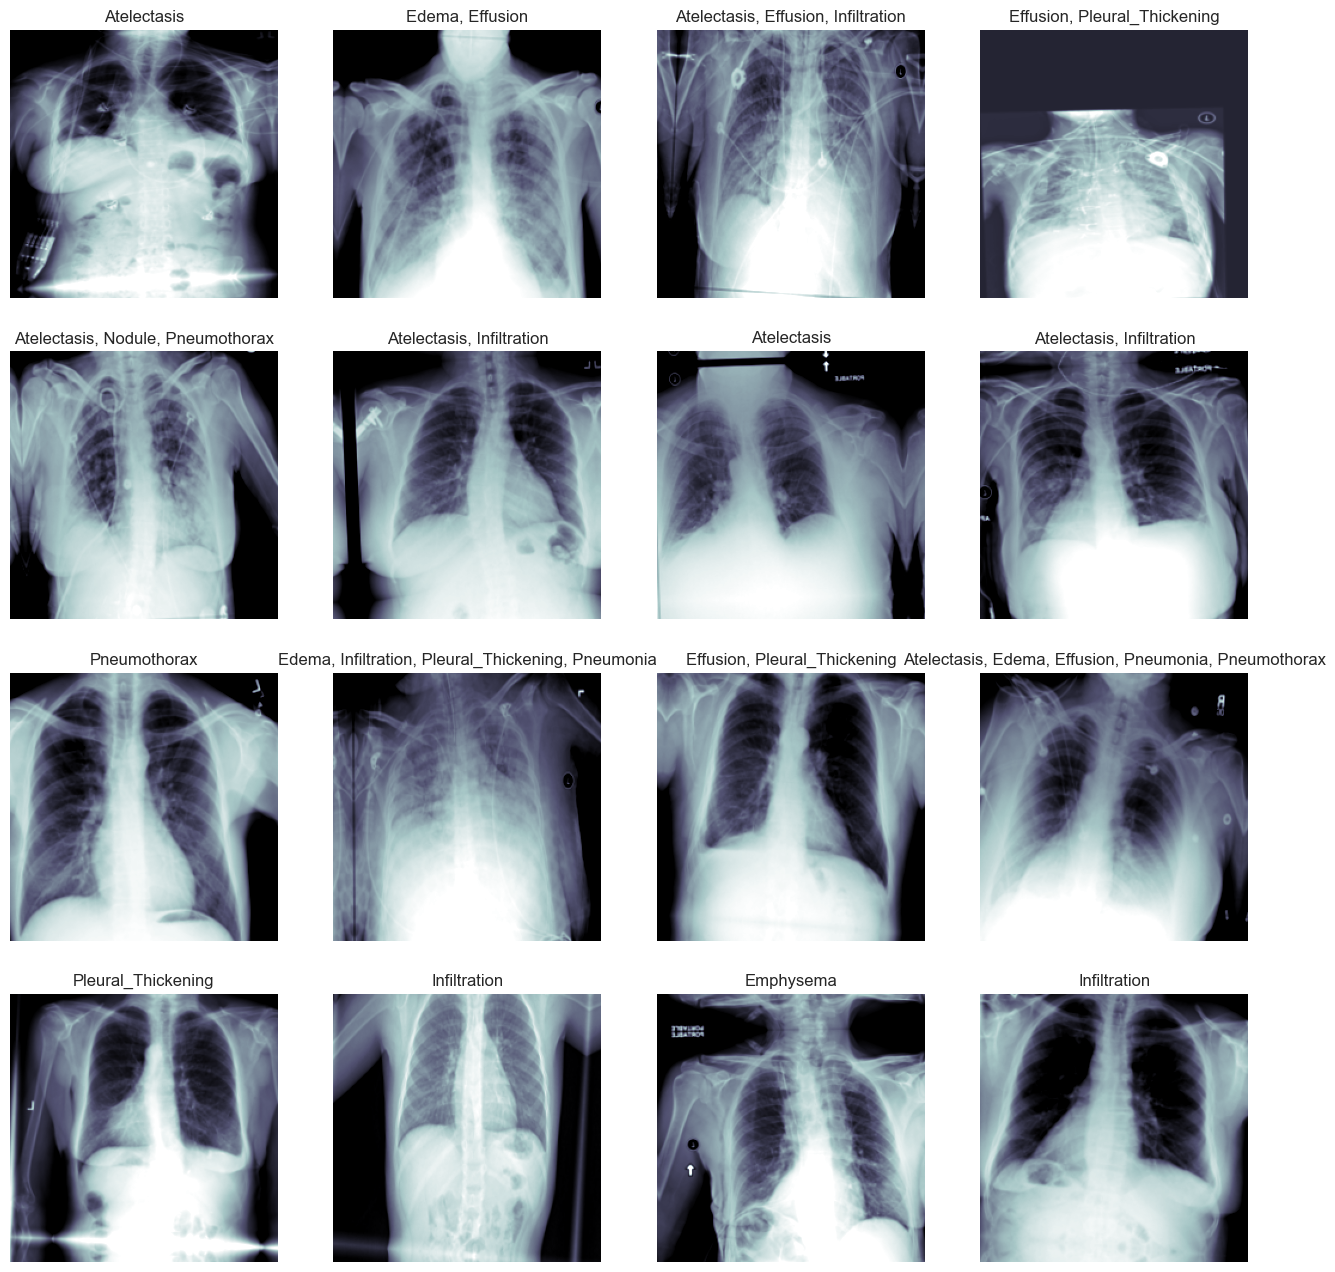

In [30]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -1.5, vmax = 1.5)
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(all_labels, c_y) 
                             if n_score>0.5]))
    c_ax.axis('off')

### Create a simple model

Here we make a simple model to train using MobileNet as a base and then adding a GAP layer (Flatten could also be added), dropout, and a fully-connected layer to calculate specific features


In [31]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
mobilenet_model = MobileNet(input_shape =  t_x.shape[1:], 
                                 include_top = False, weights = None)
multi_disease_model = Sequential()
multi_disease_model.add(mobilenet_model)
multi_disease_model.add(GlobalAveragePooling2D())
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(512))
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(len(all_labels), activation = 'sigmoid'))
multi_disease_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
multi_disease_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional) │ (None, 7, 7, 1024)     │     3,228,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 13)             │         6,669 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,759,757 (14.34 MB)

 Trainable params: 3,737,869 (14.26 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [32]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Updated file path with a descriptive name
weight_path = "224_xray_classification_best_weights.weights.h5"

# Create the ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    weight_path, 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True, 
    mode='min', 
    save_weights_only=True  # Ensures only weights are saved
)

# Early stopping to avoid overfitting
early = EarlyStopping(
    monitor="val_loss", 
    mode="min", 
    patience=5
)

# Combine callbacks
callbacks_list = [checkpoint, early]

print(f"Model weights will be saved to: {weight_path}")


Model weights will be saved to: 224_xray_classification_best_weights.weights.h5


### First Round

Here we do a first round of training to get a few initial low hanging fruit results


In [33]:
def preprocess_generator(generator, num_classes):
    for X_batch, Y_batch in generator:
        # Ensure Y_batch is a numeric array with consistent shape and dtype
        Y_batch_cleaned = []

        # Iterate through each row in Y_batch and process it
        for row in Y_batch:
            try:
                # Convert row to a numeric array, ensure float32 and correct length
                cleaned_row = np.array(row, dtype='float32')
                if cleaned_row.shape[0] != num_classes:
                    raise ValueError(f"Row length mismatch: expected {num_classes}, got {len(cleaned_row)}")
                
                Y_batch_cleaned.append(cleaned_row)
            except Exception as e:
                print(f"Error processing row {row}: {e}")
                # Add a zero vector if there's an issue
                Y_batch_cleaned.append(np.zeros(num_classes, dtype='float32'))

        # Convert the list of cleaned rows into a 2D array with dtype float32
        Y_batch_cleaned = np.asarray(Y_batch_cleaned, dtype='float32')

        # Yield the cleaned batch
        yield X_batch, Y_batch_cleaned


In [34]:
# Define the number of classes
num_classes = 13

# Preprocess test_Y
def preprocess_test_Y(test_Y, num_classes):
    test_Y_cleaned = []
    for row in test_Y:
        try:
            # Convert row to a numeric array of correct length
            cleaned_row = np.array(row, dtype='float32')
            if len(cleaned_row) != num_classes:
                raise ValueError(f"Row length mismatch: expected {num_classes}, got {len(cleaned_row)}")
        except Exception as e:
            print(f"Error processing row {row}: {e}")
            # Replace invalid rows with zeros
            cleaned_row = np.zeros(num_classes, dtype='float32')
        test_Y_cleaned.append(cleaned_row)
    return np.array(test_Y_cleaned, dtype='float32')

# Apply preprocessing
test_Y = preprocess_test_Y(test_Y, num_classes)


In [37]:
# Ensure test_X and test_Y are properly formatted
test_X = np.array(test_X, dtype='float32')
test_Y = preprocess_test_Y(test_Y, num_classes)

# Debugging output for test data
print(f"test_X shape: {test_X.shape}, dtype: {test_X.dtype}")
print(f"test_Y shape: {test_Y.shape}, dtype: {test_Y.dtype}")

# Wrap train_gen with preprocessing function
train_gen_preprocessed = preprocess_generator(train_gen, num_classes)

# Debugging output for train_gen
X_batch, Y_batch = next(train_gen_preprocessed)
print(f"X_batch shape: {X_batch.shape}, dtype: {X_batch.dtype}")
print(f"Y_batch shape: {Y_batch.shape}, dtype: {Y_batch.dtype}")

# Train the model
multi_disease_model.fit(
    train_gen_preprocessed,
    steps_per_epoch=100,
    validation_data=(test_X, test_Y),
    epochs=1,
    callbacks=callbacks_list
)


test_X shape: (1024, 224, 224, 1), dtype: float32
test_Y shape: (1024, 13), dtype: float32
X_batch shape: (32, 224, 224, 1), dtype: float32
Y_batch shape: (32, 13), dtype: float32
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.8542 - loss: 0.4129 - mae: 0.2023
Epoch 1: val_loss improved from inf to 0.34060, saving model to 224_xray_classification_best_weights.weights.h5
100/100 ━━━━━━━━━━━━━━━━━━━━ 354s 4s/step - binary_accuracy: 0.8543 - loss: 0.4127 - mae: 0.2022 - val_binary_accuracy: 0.8747 - val_loss: 0.3406 - val_mae: 0.1856


### Check Output

Here we see how many positive examples we have of each category


In [38]:
for c_label, s_count in zip(all_labels, 100*np.mean(test_Y,0)):
    print('%s: %2.2f%%' % (c_label, s_count))

Atelectasis: 23.44%
Cardiomegaly: 6.54%
Consolidation: 9.86%
Edema: 4.10%
Effusion: 27.15%
Emphysema: 4.98%
Fibrosis: 3.32%
Infiltration: 38.38%
Mass: 11.82%
Nodule: 12.40%
Pleural_Thickening: 6.45%
Pneumonia: 3.32%
Pneumothorax: 11.13%


In [39]:
pred_Y = multi_disease_model.predict(test_X, batch_size = 32, verbose = True)

32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 745ms/step


### ROC Curves

While a very oversimplified metric, we can show the ROC curve for each metric


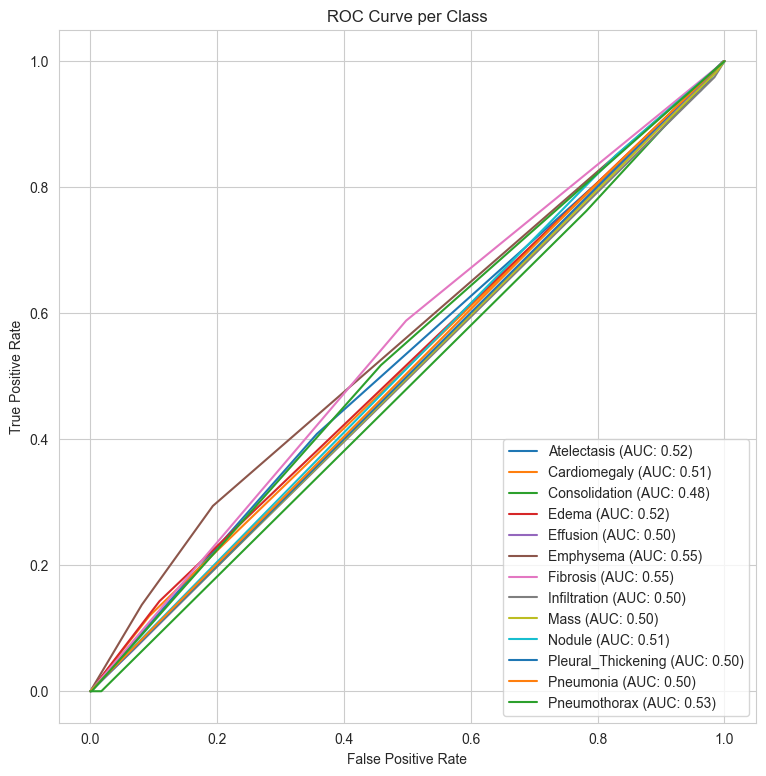

In [40]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Initialize the figure
fig, c_ax = plt.subplots(1, 1, figsize=(9, 9))

# Loop through each class and calculate the ROC curve
for idx, c_label in enumerate(all_labels):
    try:
        fpr, tpr, thresholds = roc_curve(test_Y[:, idx], pred_Y[:, idx])
        roc_auc = auc(fpr, tpr)
        c_ax.plot(fpr, tpr, label=f'{c_label} (AUC: {roc_auc:.2f})')
    except Exception as e:
        print(f"Error processing class {c_label}: {e}")

# Customize the plot
c_ax.legend(loc='lower right')
c_ax.set_title('ROC Curve per Class')
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')

# Save the figure
fig.savefig('barely_trained_net.png')

# Show the plot
plt.show()


### Continued Training

Now we do a much longer training process to see how the results improve


In [41]:

multi_disease_model.fit(
    train_gen_preprocessed,
    steps_per_epoch=614,
    validation_data=(test_X, test_Y),
    epochs=5,
    callbacks=callbacks_list
)

Epoch 1/5
614/614 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - binary_accuracy: 0.8712 - loss: 0.3475 - mae: 0.1982
Epoch 1: val_loss did not improve from 0.34060
614/614 ━━━━━━━━━━━━━━━━━━━━ 1405s 2s/step - binary_accuracy: 0.8712 - loss: 0.3475 - mae: 0.1982 - val_binary_accuracy: 0.8746 - val_loss: 0.3452 - val_mae: 0.1637
Epoch 2/5
614/614 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - binary_accuracy: 0.8761 - loss: 0.3279 - mae: 0.1919
Epoch 2: val_loss improved from 0.34060 to 0.32282, saving model to 224_xray_classification_best_weights.weights.h5
614/614 ━━━━━━━━━━━━━━━━━━━━ 1396s 2s/step - binary_accuracy: 0.8761 - loss: 0.3279 - mae: 0.1919 - val_binary_accuracy: 0.8755 - val_loss: 0.3228 - val_mae: 0.1942
Epoch 3/5
 10/614 ━━━━━━━━━━━━━━━━━━━━ 23:31 2s/step - binary_accuracy: 0.8833 - loss: 0.3149 - mae: 0.1917

KeyboardInterrupt: 

In [46]:
multi_disease_model.load_weights(weight_path)

In [47]:
pred_Y = multi_disease_model.predict(test_X, batch_size = 32, verbose = True)

32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 310ms/step


In [48]:
# look at how often the algorithm predicts certain diagnoses 
for c_label, p_count, t_count in zip(all_labels, 
                                     100*np.mean(pred_Y,0), 
                                     100*np.mean(test_Y,0)):
    print('%s: Dx: %2.2f%%, PDx: %2.2f%%' % (c_label, t_count, p_count))

Atelectasis: Dx: 23.44%, PDx: 21.17%
Cardiomegaly: Dx: 6.54%, PDx: 5.61%
Consolidation: Dx: 9.86%, PDx: 11.76%
Edema: Dx: 4.10%, PDx: 7.11%
Effusion: Dx: 27.15%, PDx: 24.19%
Emphysema: Dx: 4.98%, PDx: 5.03%
Fibrosis: Dx: 3.32%, PDx: 2.87%
Infiltration: Dx: 38.38%, PDx: 42.12%
Mass: Dx: 11.82%, PDx: 10.62%
Nodule: Dx: 12.40%, PDx: 14.47%
Pleural_Thickening: Dx: 6.45%, PDx: 6.56%
Pneumonia: Dx: 3.32%, PDx: 3.13%
Pneumothorax: Dx: 11.13%, PDx: 12.83%


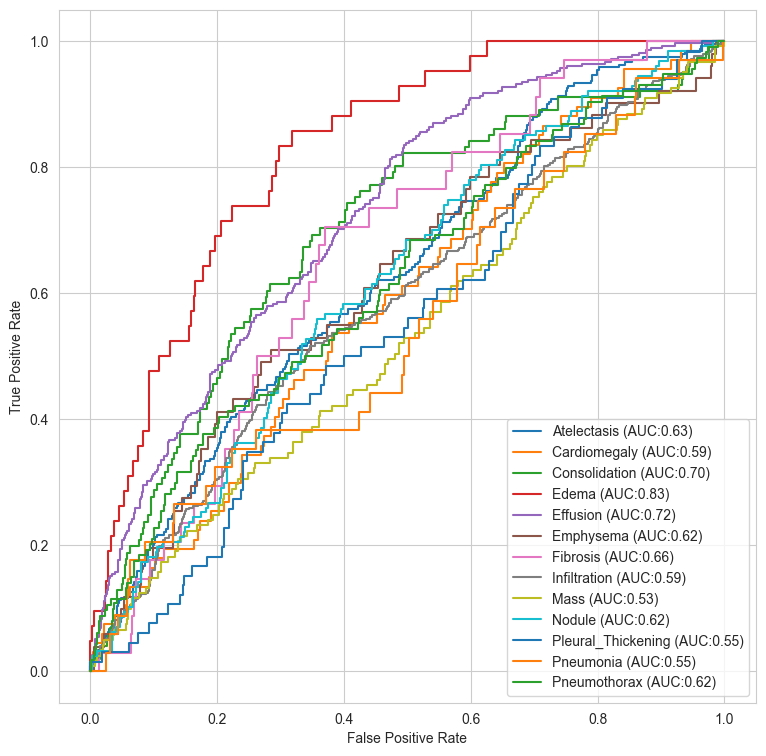

In [49]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('trained_net.png')

### Show a few images and associated predictions

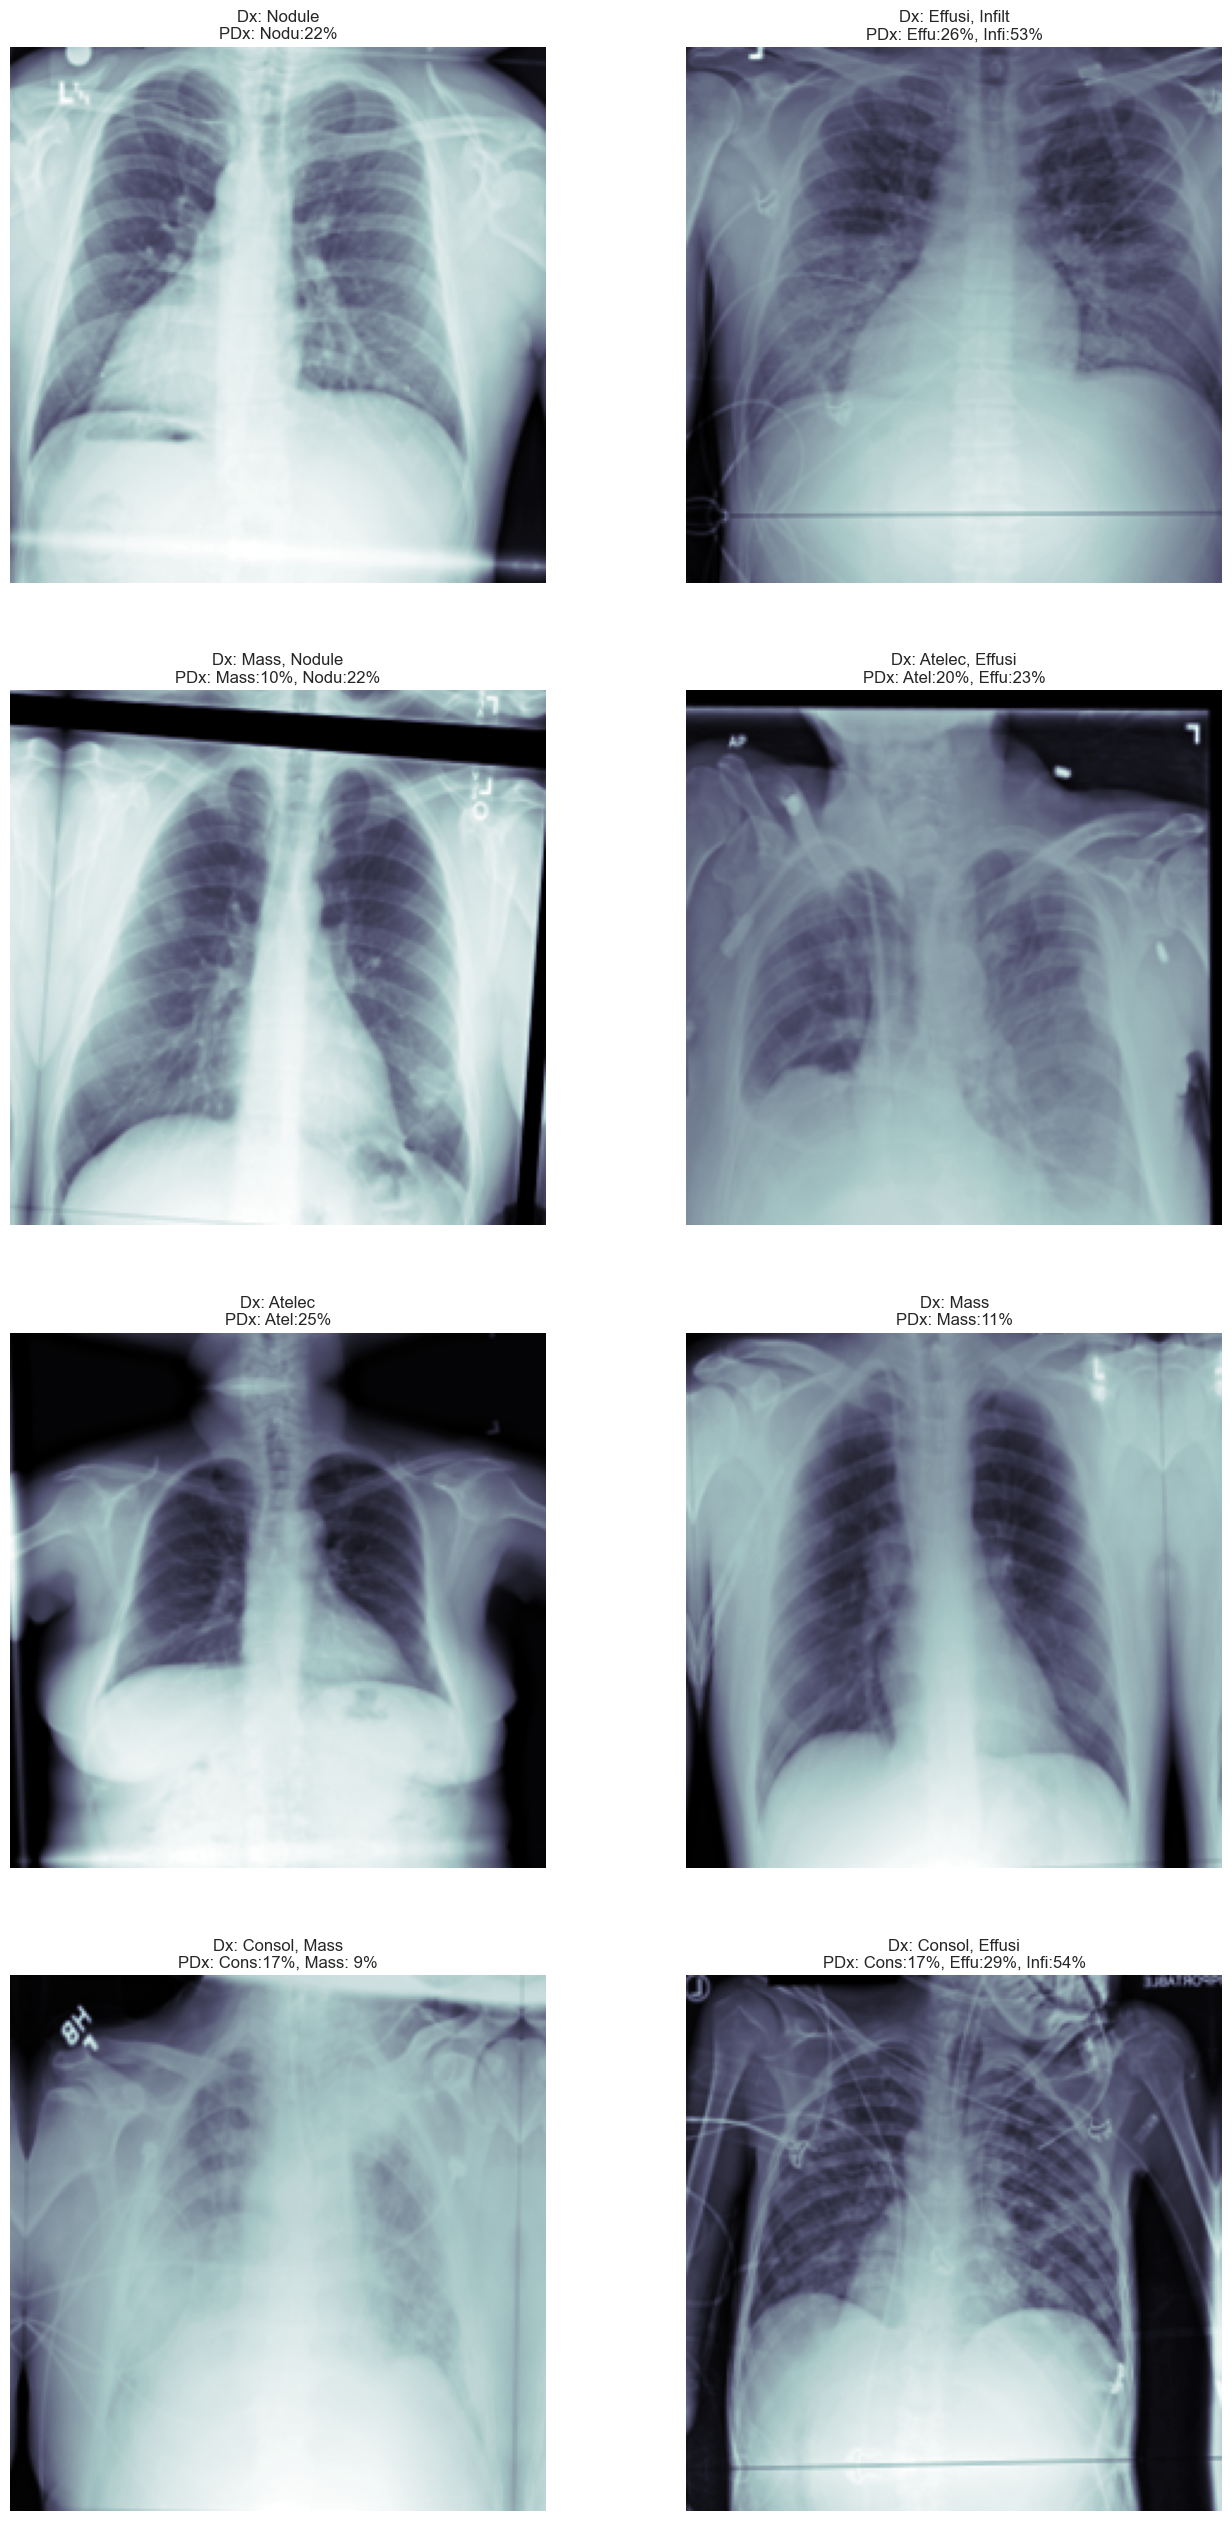

In [50]:
sickest_idx = np.argsort(np.sum(test_Y, 1)<1)
fig, m_axs = plt.subplots(4, 2, figsize = (16, 32))
for (idx, c_ax) in zip(sickest_idx, m_axs.flatten()):
    c_ax.imshow(test_X[idx, :,:,0], cmap = 'bone')
    stat_str = [n_class[:6] for n_class, n_score in zip(all_labels, 
                                                                  test_Y[idx]) 
                             if n_score>0.5]
    pred_str = ['%s:%2.0f%%' % (n_class[:4], p_score*100)  for n_class, n_score, p_score in zip(all_labels, 
                                                                  test_Y[idx], pred_Y[idx]) 
                             if (n_score>0.5) or (p_score>0.5)]
    c_ax.set_title('Dx: '+', '.join(stat_str)+'\nPDx: '+', '.join(pred_str))
    c_ax.axis('off')
fig.savefig('trained_img_predictions.png')

### Save Model for Grad-CAM++

In [51]:
import random

def find_random_pneumonia_example(df, disease_index):
    """
    Find a random example with Pneumonia from the dataframe.
    Args:
        df: Dataframe containing the dataset (e.g., train_df or valid_df).
        disease_index: Index of Pneumonia in the multi-hot vector.
    Returns:
        Random image path for Pneumonia.
    """
    # Filter rows where Pneumonia is present
    pneumonia_df = df[df['disease_vec'].apply(lambda x: x[disease_index] == 1)]
    
    # Check if there are any Pneumonia examples
    if pneumonia_df.empty:
        raise ValueError("No Pneumonia examples found in the dataset.")
    
    # Randomly select one example
    random_row = pneumonia_df.sample(n=1).iloc[0]
    img_path = random_row['Image Index']
    return img_path

# Pneumonia class index
pneumonia_idx = all_labels.index("Pneumonia")

# Find a random Pneumonia example
random_pneumonia_image_path = find_random_pneumonia_example(valid_df, pneumonia_idx)
print("Random Pneumonia Example:", random_pneumonia_image_path)


Random Pneumonia Example: 00029654_000.png


In [52]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

base_dir = 'dataset/images-224/images-224/'  # Base directory for images

# Function to preprocess the image
def preprocess_image(img_path, target_size):
    img = load_img(img_path, target_size=target_size, color_mode='grayscale')
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize pixel values
    return img_array




Full path to Pneumonia image: dataset/images-224/images-224/00013211_000.png


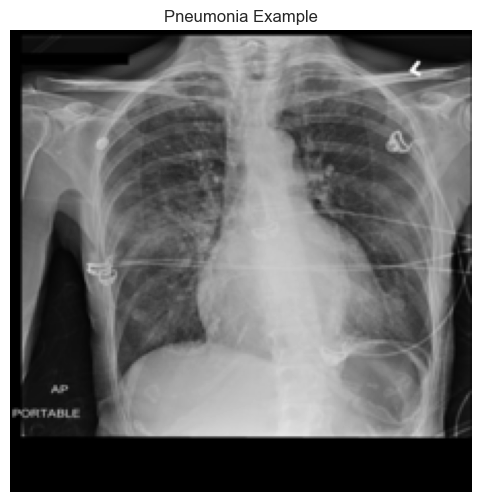

In [53]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Find a random Pneumonia example
random_pneumonia_image_path = find_random_pneumonia_example(valid_df, pneumonia_idx)

# Join base_dir and random_pneumonia_image_path to create the full path
full_image_path = os.path.join(base_dir, random_pneumonia_image_path)
print("Full path to Pneumonia image:", full_image_path)

# Load and preprocess the image
img = load_img(full_image_path, target_size=(224, 224), color_mode="grayscale")
img_array = img_to_array(img)  # Shape: (224, 224, 1)
img_array /= 255.0  # Normalize pixel values to [0, 1]

# Display the image
plt.figure(figsize=(6, 6))
plt.title("Pneumonia Example")
plt.imshow(img_array[:, :, 0], cmap="gray")
plt.axis("off")
plt.show()

# Prepare the image for model inference
img_array = np.expand_dims(img_array, axis=0)  # Shape: (1, 224, 224, 1)


In [54]:

# Save the entire model for Grad-CAM++
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input

model_save_path = "full_model_gradcam.h5"
multi_disease_model.save(model_save_path)
print(f"Model saved at {model_save_path}")

# To load the model later
loaded_model = load_model(model_save_path)
print("Model successfully loaded for Grad-CAM++")

Model saved at full_model_gradcam.h5


Model successfully loaded for Grad-CAM++


In [56]:
import tensorflow as tf
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model

# Define the input tensor
inputs = Input(shape=(224, 224, 1))  # Grayscale input

# Load EfficientNetB0 with input_tensor specified
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights=None,  # No weights for grayscale input (retrain or fine-tune)
    input_tensor=inputs
)

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(13, activation='sigmoid')(x)  # 13 classes (multi-label classification)

# Build the final model
multi_disease_model = Model(inputs=base_model.input, outputs=outputs)



In [57]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import os

def preprocess_image(img_path, target_size):
    """
    Preprocess the input image for the model.
    Args:
        img_path: Path to the image.
        target_size: Tuple (height, width) to resize the image.
    Returns:
        Preprocessed image array of shape (1, height, width, 1).
    """
    # Load the image in grayscale
    img = load_img(img_path, target_size=target_size, color_mode="grayscale")
    img_array = img_to_array(img)  # Shape: (224, 224, 1)

    # Expand dimensions to add batch size and normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Shape: (1, 224, 224, 1)
    img_array /= 255.0  # Normalize pixel values to [0, 1]
    return img_array

# Base directory and sample Pneumonia image

pneumonia_idx = 8  # Assuming Pneumonia is the 8th class
random_pneumonia_image_path = full_image_path  # Replace with actual file path


# Preprocess the image
img_array = preprocess_image(full_image_path, (224, 224))
print("Preprocessed image shape:", img_array.shape)


Preprocessed image shape: (1, 224, 224, 1)


In [58]:
def grad_cam_plus_plus(model, img_array, last_conv_layer_name, class_idx):
    """
    Compute Grad-CAM++ heatmap for the specified class index using tf.GradientTape.
    Args:
        model: Trained model.
        img_array: Preprocessed input image (1, H, W, C).
        last_conv_layer_name: Name of the convolutional layer to use for Grad-CAM++.
        class_idx: Class index for which the heatmap is generated.
    Returns:
        Heatmap (H, W).
    """
    # Create a model to output both the feature map and predictions
    grad_model = Model(
        inputs=model.input,
        outputs=[
            model.get_layer(last_conv_layer_name).output,
            model.output
        ]
    )

    with tf.GradientTape() as tape1, tf.GradientTape() as tape2, tf.GradientTape() as tape3:
        # Forward pass
        conv_output, predictions = grad_model(img_array)
        pred_class_output = predictions[:, class_idx]

        # Compute first, second, and third-order gradients
        grads = tape1.gradient(pred_class_output, conv_output)
        grads_squared = tape2.gradient(tf.square(pred_class_output), conv_output)
        grads_third = tape3.gradient(tf.pow(pred_class_output, 3), conv_output)

    # Compute alpha values for Grad-CAM++
    global_sum = tf.reduce_sum(conv_output, axis=(0, 1, 2))
    alpha_num = grads_squared
    alpha_denom = 2 * grads_squared + grads_third * global_sum
    alpha_denom = tf.where(alpha_denom != 0.0, alpha_denom, tf.ones_like(alpha_denom))
    alphas = alpha_num / alpha_denom

    # Compute weights
    weights = tf.reduce_sum(alphas * tf.nn.relu(grads), axis=(0, 1))

    # Generate the heatmap
    heatmap = tf.reduce_sum(weights * conv_output[0], axis=-1)
    heatmap = tf.maximum(heatmap, 0)  # ReLU activation
    heatmap /= tf.reduce_max(heatmap)  # Normalize to [0, 1]
    return heatmap.numpy()  # Convert to NumPy array at the end


image_rgb shape: (224, 224, 3)
heatmap_colored shape: (7, 7, 3)


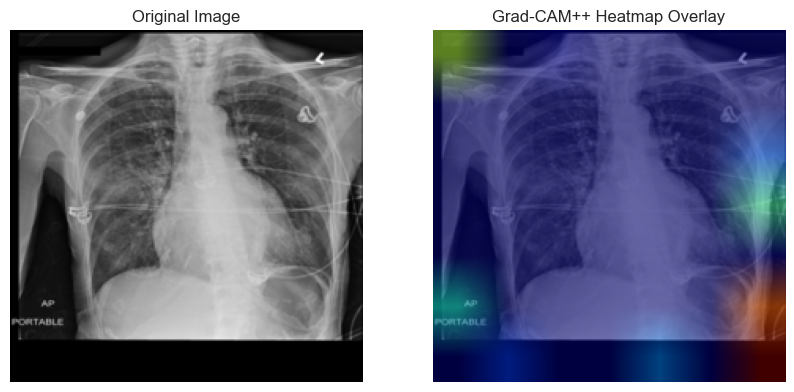

In [59]:
import matplotlib.pyplot as plt
import cv2

def overlay_heatmap(heatmap, image, alpha=0.5, colormap='jet'):
    """
    Overlay the heatmap on the original image.
    Args:
        heatmap: The Grad-CAM++ heatmap (H, W), normalized to [0, 1].
        image: Original grayscale image (H, W).
        alpha: Blending factor for overlay.
        colormap: Colormap for heatmap visualization.
    Returns:
        Overlayed image (H, W, 3).
    """
    import matplotlib.pyplot as plt

    # Normalize heatmap to 0-255
    heatmap = np.uint8(255 * heatmap)

    # Apply colormap
    colormap = plt.cm.get_cmap(colormap)
    heatmap_colored = colormap(heatmap)
    heatmap_colored = np.uint8(heatmap_colored[:, :, :3] * 255)  # Remove alpha channel

    # Convert grayscale image to RGB
    if len(image.shape) == 2:  # If grayscale
        image_rgb = cv2.cvtColor(np.uint8(image), cv2.COLOR_GRAY2RGB)
    else:
        image_rgb = image

    # Debug: Print shapes
    print("image_rgb shape:", image_rgb.shape)
    print("heatmap_colored shape:", heatmap_colored.shape)

    # Resize heatmap to match the original image size
    heatmap_colored_resized = cv2.resize(heatmap_colored, (image_rgb.shape[1], image_rgb.shape[0]))

    # Blend the heatmap with the original image
    overlay = cv2.addWeighted(image_rgb, 1 - alpha, heatmap_colored_resized, alpha, 0)
    return overlay


# Generate the Grad-CAM++ heatmap
heatmap = grad_cam_plus_plus(multi_disease_model, img_array, "top_conv", pneumonia_idx)

# Overlay heatmap on the original image
original_img = img_array[0, :, :, 0] * 255
overlay_img = overlay_heatmap(heatmap, original_img)

# Plot the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_img, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Grad-CAM++ Heatmap Overlay")
plt.imshow(overlay_img)
plt.axis('off')

plt.show()
